---
layout: post

title: Ordovician Silicate Weathering
---

In multi-million years time scale, the Earth's climate is mainly controlled by the $CO_2$ concentrations in the atmosphere, which largely depends on the volcanic degassing as the main source, and silicate weathering as the sink. Geologist are able to constrain the balance between these processes using strontium isotope of marine carbonate rocks.

In this post, I am trying to recreate a numerical model published by Young et al (2009).

The goal of this model is to simulate changes in silicate weathering (inversely) during a time period called the Ordoviaian.

**Reference**: 

Young, S.A., Saltzman, M.R., Foland, K.A., Linder, J.S., and Kump, L.R., 2009, A major drop in seawater 87Sr/86Sr during the Middle Ordovician (Darriwilian): Links to volcanism and climate? Geology, v. 37, p. 951–954, [doi:10.1130/G30152A.1.](https://doi.org/:10.1130/G30152A.1.)


In [1]:
# Import python packages
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from datetime import datetime
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

%matplotlib inline

### Differential equation (1):

Amount of phosphate in the ocean ($M_{OP}$)

$$\frac{d(M_{OP})}{dt}=F_{wp} - F_{bp}$$

where:

$M_{OP}$ = amount of phosphate in the oceans, initial value = $3 \times 10^3(\times 10^{12}mol/ky)$

$F_{wP}$ = flux of phosphate into the oceans ($\times 10^{12} \frac{mol}{ky}$) = $30 \times weathearbility \times ClimateWeatheringFactor$

$F_{bP}$ = flux of phosphate out of the oceans due to burial ($\times 10^{12} \frac{mol}{ky}$) = $30 \times \frac{M_{OP}}{M_{OP_{initial}}}$

In [2]:
def Mop(Fwp, Fbp):
    '''
    
    Mop : Mass of phosphate in the oceans
    Fwp : Flux of phosphate into the oceans
    Pbp : flux of phosphate out of the oceans due to burial
    dt  : time interval
    y   : dummy variable to store results
    
    '''
    y = (Fwp - Fbp)
    return y

def Fwp(weatherability, ClimateWeatheringFactor):
    '''
    
    Flux of phosphate to the oceans (10^12 mol per ky)
    
    '''
    y = 30 * weatherability * ClimateWeatheringFactor
    return y

def Fbp(Mop, Mop_initial):
    y = 30 * (Mop / Mop_initial)
    return y

### Differential equation (2):

Amount of inorganic carbon in the ocean and atmosphere ($M_{OC}$)

$$\frac{d(M_{OC})}{dt}=F_{worg} + F_{volc} - F_{borg} - F_{wsil}$$

where:

$M_{OC}$ = total inorganic carbon in the oceans and atmosphere, initial value = $1.61 \times 10^7(\times 10^{12}mol/ky)$

$F_{worg}$ = organic carbon weathering flux ($\times 10^{12} \frac{mol}{ky}$) = $10000 \times weathearbility \times ClimateWeatheringFactor$

$F_{volc}$ = CO2 released from volcanic activity (specified)($\times 10^{12} \frac{mol}{ky}$)

$F_{borg}$ = organic carbon burial flux ($\times 10^{12} \frac{mol}{ky}$) = $F_{bp} \times C/P$

$F_{wsil}$ = Silicate weathering ($\times 10^{12} \frac{mol}{ky}$) = $6000 \times weathearbility \times ClimateWeatheringFactor$

In [3]:
def Moc(Fworg, Fvolc, Fborg, Fwsil):
    y = (Fworg + Fvolc - Fborg - Fwsil)
    return y

def Fworg(weatherability, ClimateWeatheringFactor):
    y = 1e4 * weatherability * ClimateWeatheringFactor
    return y

def Fborg(Fbp, CtoP=333):
    y = Fbp * CtoP
    return y

def Fwsil(weatherability, ClimateWeatheringFactor):
    y = 6e3 * weatherability * ClimateWeatheringFactor
    return y

### Differential equation (3):

Strontium isotopic ratio $(^{87}Sr/^{86}Sr)$ in seawater ($r_{o}$)

$$\frac{d(r_{o})}{dt}=\frac{\frac{1+r_o}{1+r_b}(r_R - r_o) \times F_{wSr} + \frac{1+r_o}{1+r_b}(r_B - r_o) \times F_{volc} \times f_{hyd}}{M_{o,Sr}}$$

where:

$r_o$ = $(^{87}Sr/^{86}Sr)$ ratio in seawater, initial value = $0.7091$

$r_B$ = $(^{87}Sr/^{86}Sr)$ ratio of basalt = $0.7037$ (Stern, 1982)

$r_R$ = $(^{87}Sr/^{86}Sr)$ ratio of riverine fluxes :


if model time < 20000 ky:
    
- $r_R$ = $0.7106 - time(ky) \times 1 \times 10^{-8}$

else:
    
- $r_R$ = $\frac{(0.7106 + (weatherability -1) \times 0.7043)}{weatherability}$

$F_{wSr}$ = Flux of strontium into the oceans ($\times 10^{12} \frac{mol}{ky}$) = $30 \times weathearbility \times ClimateWeatheringFactor$

$F_{volc}$ = CO2 released from volcanic activity (specified)($\times 10^{12} \frac{mol}{ky}$)

$f_{hyd}$ = hydrothermal fraction of (total) volcanism = $1.75 \times 10^{-3}$ (based on modern values)

$M_{o,Sr}$ = Amount of Sr in the ocean = $19 \times 10^4 (\times 10^{12}mol)$ (held constant)

In [4]:
def Ro(ro, rb, rr, Fwsr, Fvolc, fhyd, Mosr):
    y = (((1+ro)/(1+rb)) * (rr-ro) * Fwsr + ((1+ro)/(1+rb)) * (rb-ro) * Fvolc * fhyd) / (Mosr)
    return y

def Rr(time, weatherability):
    if time < 2e4:
        y = 0.7106 - time * 1e-8
    else:
        y = (0.7104 + (weatherability - 1) * 0.7043) / (weatherability)
    return y

def Fwsr(weatherability, climateweatheringfactor):
    y = 30 * weatherability * climateweatheringfactor
    return y

### $pCO_2$ Equations:

$$pCO_2 = \left(\frac{M_{OC}}{M_{OC,initial}}\right) ^2 \times 5000 $$

where:

$M_{OC, initial}$ = $1.60 \times 10^7 (\times 10^{12}mol)$

$$ClimateWeatheringFactor = \left(\frac{pCO_2}{pCO_{2, initial}}\right)^{0.3}$$

where:

$pCO_{2, initial}$ = $5000$ ppmV (Berner, 2006)

In [5]:
def pCO2(Moc, Moc_0=1.61e7, pCO2_0=5000):
    y = (Moc / Moc_0)**2 * pCO2_0
    return y

def CWF(pCO2, pCO2_0=5000):
    y = (pCO2/pCO2_0)**0.3
    return y

### Fixed parameters initialization
1. time array

In [6]:
dt = 1

# time
time_min = 0
time_max = 45000
time = np.arange(time_min, time_max, dt)

# array size
t = len(time)

age = 484 - time/1e3

2. Weatherability

In [7]:
tie_points=[463.6, 460, 448, 443.8]

for i in tie_points:
    print(i, 'index = ', int(np.where(age == i)[0]))

463.6 index =  20400
460 index =  24000
448 index =  36000
443.8 index =  40200


Text(0.5, 1.0, 'Weatherability')

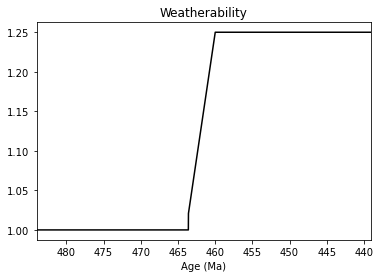

In [8]:
W = np.ones(t)


W[20400:24000] = np.linspace(1.02, 1.25, (24000-20400))
W[24000:] = W[24000] * 1.25

plt.plot(age, W, 'k-')
plt.xlim(max(age), min(age))
plt.xlabel('Age (Ma)')
plt.title('Weatherability')


In [9]:
# pCO2
pco2= np.ones(t) # array for pCO2
pco2_0 = 5000     # initial value of pCO2
pco2[0] = pco2_0

# Climate Weathering Factor (CWP)
cwf = np.ones(t)
cwf[0] = CWF(pco2[0])

3. Carbon dioxide released from volcanic activities ($F_{volc}$)

Text(0.5, 1.0, '$CO_2$ from volcanic flux')

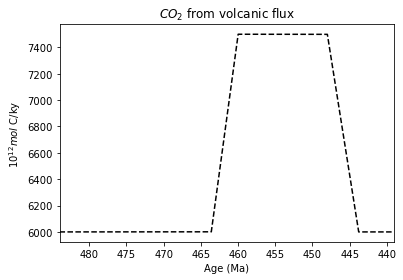

In [10]:
# Initialize Fvolc
fvolc = np.ones(t) * 6000 # initial value = 6000 (Kump and Arthur, 1999)

fvolc[20400:24000] = np.linspace(6000, 7500, (24000-20400))
fvolc[24000:36000] = fvolc[24000:36000] + 1500
fvolc[36000:40200] = np.linspace(7500, 6000, (40200-36000))

plt.plot(age, fvolc, 'k--')
plt.xlim(max(age), min(age))
plt.xlabel('Age (Ma)')
plt.ylabel('$10^{12}mol$ C/ky')
plt.title('$CO_2$ from volcanic flux')

4. Sr in the ocean

Text(0.5, 1.0, 'Sr in the ocean')

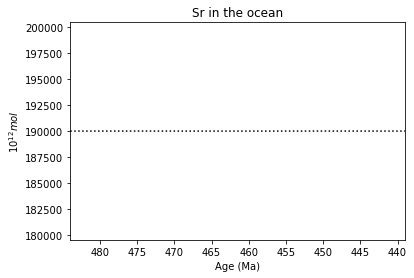

In [11]:
# Initialize Mosr
mosr = np.ones(t) * 19e4

plt.plot(age, mosr, 'k:')
plt.xlim(max(age), min(age))
plt.xlabel('Age (Ma)')
plt.ylabel('$10^{12}mol$')
plt.title('Sr in the ocean')

In [12]:
#Initialize arrays for diff.eq #1

mop = np.ones(t)  # array for Mop
mop_0 = 3e3       # initial value of Mop
mop[0] = mop_0    # assign initial value into array

fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

In [13]:
# Initialize arrays for diff.eq #2

moc = np.ones(t)  # array for Moc
moc_0 = 1.61e7    # initial value of Moc
moc[0] = moc_0    # assign initial value into array

fworg = Fworg(W, cwf)
fborg = Fborg(fbp)
fwsil = Fwsil(W, cwf)

In [14]:
# Initialize arrays for diff.eq #3

ro = np.ones(t)
ro_0 = 0.7091
ro[0] = ro_0

rb = np.ones(t) * 0.7037
fhyd = np.ones(t) * 1.75e-3

rr = np.ones(t)
rr[0] = Rr(time[0], W[0])

fwsr = np.ones(t)
fwsr[0] = Fwsr(W[0], cwf[0])

### Main modeling script

In [15]:
for i in range(t-1):
    
    fworg[i+1] = Fworg(W[i], cwf[i])
    fborg[i+1] = Fborg(fbp[i])
    fwsil[i+1] = Fwsil(W[i], cwf[i])
    moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])
    
    pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
    cwf[i+1] = CWF(pco2[i])
    
    
    fwp[i+1] = Fwp(W[i], cwf[i])
    fbp[i+1] = Fbp(mop[i], mop_0)
    mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])
    
        
    rr[i+1] = Rr(time[i], W[i])
    fwsr[i+1] = Fwsr(W[i], cwf[i])
    ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], fvolc[i], fhyd[i], mosr[i])

### Plotting

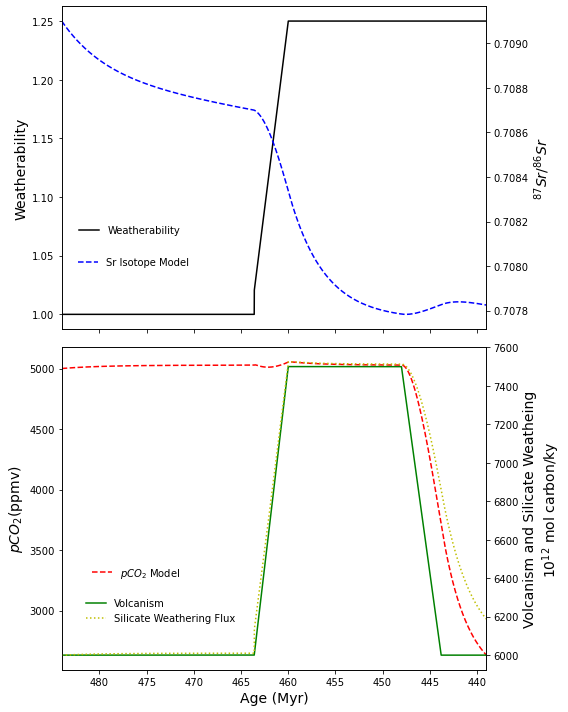

In [16]:
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(8,10))

ax1.plot(age, W, 'k-', label='Weatherability')
ax1.legend(bbox_to_anchor=(0.3, 0.35), edgecolor='None')
ax1.set_ylabel('Weatherability', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(age, ro, 'b--', label= 'Sr Isotope Model')
ax2.set_ylabel('$^{87}Sr/^{86}Sr$', fontsize=14)
ax2.legend(bbox_to_anchor=(0.32, 0.25), edgecolor='None')

ax3.plot(age, pco2, 'r--', label= '$pCO_2$ Model')
ax3.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax3.legend(bbox_to_anchor=(0.3, 0.35), edgecolor='None')

ax4 = ax3.twinx()
ax4.plot(age, fvolc, 'g-', label='Volcanism')
ax4.plot(age, fwsil, 'y:', label='Silicate Weathering Flux')
ax4.set_ylabel('Volcanism and Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.legend(bbox_to_anchor=(0.43, 0.25), edgecolor='None')

ax3.set_xlabel('Age (Myr)', fontsize=14)
ax3.set_xlim(max(age), min(age))

plt.tight_layout()